# Forecasting Example

In this notebook, we have developed code to show an example of how to obtain and plot both mean and interval forecast of a fitted UnnobservedComponentGAS model.

## Import packages

In [ ]:
import Pkg
Pkg.add(url = "https://github.com/LAMPSPUC/UnobservedComponentsGAS.git")

using UnobservedComponentsGAS, Plots, CSV, DataFrames, Metrics

## Reading Energy Consumption data

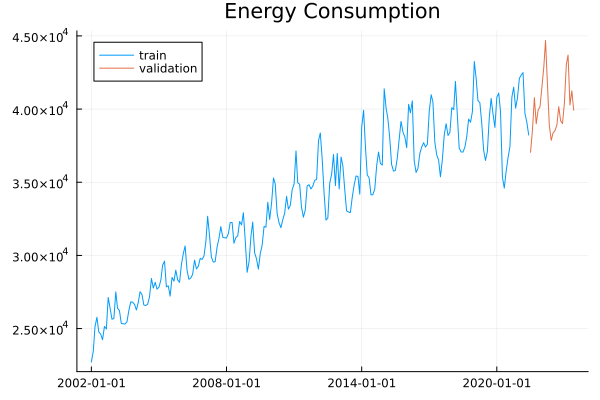

In [51]:
data = CSV.read("data/energy_consumption.csv", DataFrame)

steps_ahead = 24
y_train     = data[1:end-steps_ahead, 2]
y_val       = data[end-steps_ahead+1:end, 2] 
dates_train = data[1:end-steps_ahead, 1]
dates_val   = data[end-steps_ahead+1:end, 1]

plot(title = "Energy Consumption")
plot!(dates_train, y_train, label = "train")
plot!(dates_val, y_val, label = "validation")

## Define a Score-Driven Model

Model specifications:
 - Distribution: LogNormal
 - Only the first parameter as time varying
 - d = 1
 - 500 scenarios to obtain the forecast
 - level component: random walk with slope process
 - seasonality component: deterministic with 12 seasonal periods (monthly seasonality)
 - ar component: missing

Since we have only the first parameter as time varying, we can pass a string "dynamic" instead of a vector of strings ["dynamic", ""].
 - *Example*: we are able to define level = "random walk slope" instead of level = ["random walk slope", ""]


In [52]:
dist                    = UnobservedComponentsGAS.NormalDistribution()
time_varying_parameters = [true, false]
d                       = 0.5
num_scenarious          = 500

level       = "random walk slope"
seasonality = "deterministic 12"
ar          = 2

model = UnobservedComponentsGAS.GASModel(dist, time_varying_parameters, d, level,seasonality, ar);

## Fit and Forecast the specified model

In [53]:
fitted_model = UnobservedComponentsGAS.fit(model, y_train; robust = false);
forec        = UnobservedComponentsGAS.predict(model, fitted_model, y_train, steps_ahead, num_scenarious);
scenarios    = UnobservedComponentsGAS.simulate(model, fitted_model, y_train, steps_ahead, num_scenarious);

### The forec object

The *forec* object, returned by the function *predict()* is a dictionary with 2 keys:
 - mean: keeps a vector that represents the mean forecast
 - intervals: a dictionary the keeps vector for 4 intervals (80% and 95% confidence intervals, both with upper and lower)

The *scenarios* object, returned by the function *simulate()* is a matrix of size steps_ahead X num_scenarios with the simulated forecast series.

## Plot Mean Forecast with Confidence Intervals

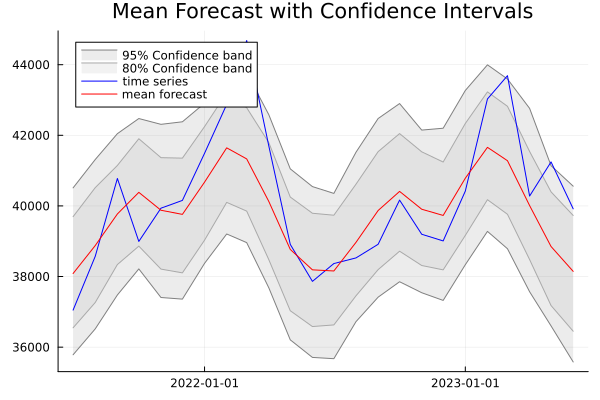

In [54]:
plot(title = "Mean Forecast with Confidence Intervals")
plot!(dates_val, forec["intervals"]["95"]["lower"], fillrange = forec["intervals"]["95"]["upper"], fillalpha = 0.15, color = :grey, label = "95% Confidence band")
plot!(dates_val, forec["intervals"]["80"]["lower"], fillrange = forec["intervals"]["80"]["upper"], fillalpha = 0.15, color = :darkgrey, label = "80% Confidence band")
plot!(dates_val, forec["intervals"]["95"]["upper"], label = "", color = :grey)
plot!(dates_val, forec["intervals"]["80"]["upper"], label = "", color = :darkgrey)
plot!(dates_val, y_val, label = "time series", color = :blue)
plot!(dates_val, forec["mean"], label = "mean forecast", color = :red)

## Plot Mean Forecast with Scenarios

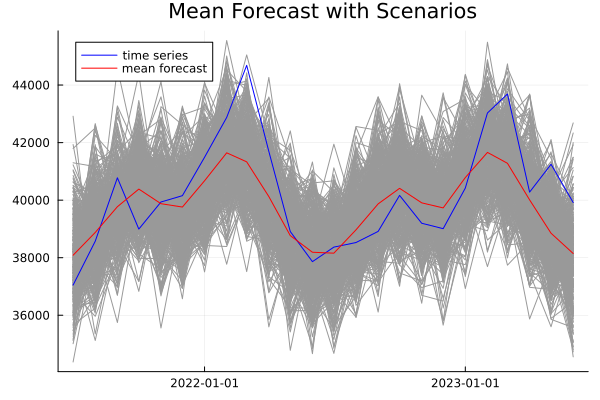

In [55]:
plot(title = "Mean Forecast with Scenarios")
plot!(dates_val, scenarios, label = "", color = :grey60)
plot!(dates_val, y_val, label = "time series", color = :blue)
plot!(dates_val, forec["mean"], label = "mean forecast", color = :red)

## Accuracy Metrics

There are inumerous useful metrics to quantify the forecast accurary, namely MSE, RMSE, MAPE, MAE. We chose to ilustrate this example with the RMSE metric, from the Metrics.jl package.

In [56]:
using Metrics
rmse_val = sqrt(Metrics.mse(forec["mean"], y_val))
println("Validation RMSE = ", round(rmse_val, digits = 3))

Validation RMSE = 1279.511
